In [4]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=05f13c3585d9f5fbc9a9bfbdb12e2a7cedc802551854b8712abba18b8d613118
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [67]:
class StockClusteringSystem:
    def __init__(self, tickers, start_date, end_date):
        """
        Initialize the stock clustering system

        Parameters:
        tickers (list): List of stock tickers
        start_date (str): Start date in 'YYYY-MM-DD' format
        end_date (str): End date in 'YYYY-MM-DD' format
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.data = {}
        self.features = pd.DataFrame()

    def fetch_data(self):
        """Fetch historical data for all tickers"""
        for ticker in self.tickers:
            stock = yf.Ticker(ticker)
            self.data[ticker] = stock.history(start=self.start_date, end=self.end_date)

    def calculate_returns(self, ticker):
        """Calculate daily, monthly, and yearly returns"""
        df = self.data[ticker]

        # Daily returns
        daily_returns = df['Close'].pct_change()

        # Monthly returns
        monthly_returns = df['Close'].resample('M').last().pct_change()

        # Yearly returns
        yearly_returns = df['Close'].resample('Y').last().pct_change()

        return {
            'daily_return_mean': daily_returns.mean(),
            'daily_return_std': daily_returns.std(),  # Volatility
            'monthly_return_mean': monthly_returns.mean(),
            'yearly_return_mean': yearly_returns.mean()
        }

    def calculate_technical_indicators(self, ticker):
        """Calculate technical indicators for a given ticker"""
        df = self.data[ticker]

        # Calculate RSI
        rsi = ta.momentum.RSIIndicator(df['Close']).rsi()

        # Calculate MACD
        macd = ta.trend.MACD(df['Close'])
        macd_diff = macd.macd_diff()

        # Calculate Moving Averages
        ma50 = df['Close'].rolling(window=50).mean()
        ma200 = df['Close'].rolling(window=200).mean()

        return {
            'rsi_mean': rsi.mean(),
            'macd_diff_mean': macd_diff.mean(),
            'ma50_ma200_ratio': (ma50.iloc[-1] / ma200.iloc[-1]) if len(ma50) > 0 and len(ma200) > 0 else 0
        }

    def calculate_financial_metrics(self, ticker):
        """Calculate financial metrics for a given ticker"""
        stock = yf.Ticker(ticker)
        info = stock.info

        try:
            pe_ratio = info.get('forwardPE', 0)
            dividend_yield = info.get('dividendYield', 0)
            market_cap = info.get('marketCap', 0)
            beta = info.get('beta', 0)
        except:
            pe_ratio, dividend_yield, market_cap, beta = 0, 0, 0, 0

        return {
            'pe_ratio': pe_ratio,
            'dividend_yield': dividend_yield,
            'market_cap': market_cap,
            'beta': beta
        }

    def create_feature_matrix(self):
        """Create feature matrix for clustering"""
        feature_data = []

        for ticker in self.tickers:
            # Get all features
            returns = self.calculate_returns(ticker)
            technical = self.calculate_technical_indicators(ticker)
            financial = self.calculate_financial_metrics(ticker)

            # Combine all features
            features = {
                'ticker': ticker,
                **returns,
                **technical,
                **financial
            }

            feature_data.append(features)

        self.features = pd.DataFrame(feature_data)
        self.features.set_index('ticker', inplace=True)

    def preprocess_features(self):
        """Preprocess features for clustering"""
        # Remove any infinite values
        self.features = self.features.replace([np.inf, -np.inf], np.nan)

        # Fill NaN values with column mean
        self.features = self.features.fillna(self.features.mean())

        # Scale features
        scaler = StandardScaler()
        self.scaled_features = scaler.fit_transform(self.features)

    def perform_clustering(self, n_clusters=3):
        """Perform K-means clustering"""
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.clusters = self.kmeans.fit_predict(self.scaled_features)

        # Add clusters back to features DataFrame
        self.features['Cluster'] = self.clusters

        # Calculate silhouette score
        silhouette_avg = silhouette_score(self.scaled_features, self.clusters)
        print(f"Silhouette Score: {silhouette_avg}")

    def get_cluster_characteristics(self):
        """Get characteristics of each cluster"""
        cluster_means = self.features.groupby('Cluster').mean()

        # Calculate rank for volatility, returns, and Sharpe ratio
        volatility_rank = cluster_means['daily_return_std'].rank()
        returns_rank = cluster_means['daily_return_mean'].rank()
        sharpe_ratio = cluster_means['daily_return_mean'] / cluster_means['daily_return_std']
        sharpe_rank = sharpe_ratio.rank()

        # Combine ranks with unique weights
        risk_score = (volatility_rank * 1e9) + (returns_rank * 1e8) + (sharpe_rank * 1e7)

        # Print risk scores
        print("Risk Scores:", risk_score)

        # Assign categories based on max, min, and mid values
        max_score = risk_score.max()
        min_score = risk_score.min()

        risk_mapping = {}
        for cluster in range(len(cluster_means)):
            if risk_score[cluster] == max_score:
                risk_mapping[cluster] = 'Aggressive'
            elif risk_score[cluster] == min_score:
                risk_mapping[cluster] = 'Safe'
            else:
                risk_mapping[cluster] = 'Semi-Aggressive'

        return risk_mapping






    def get_recommendations(self, risk_preference):
        """Get stock recommendations with improved error handling"""
        risk_mapping = self.get_cluster_characteristics()

        # Check if we have any mappings
        if not risk_mapping:
            print(f"Warning: No valid risk mappings found")
            return []

        # Find clusters matching the risk preference
        matching_clusters = [k for k, v in risk_mapping.items() if v == risk_preference]

        if not matching_clusters:
            print(f"Warning: No clusters found for risk preference '{risk_preference}'")
            return []

        # Get all stocks from matching clusters
        recommendations = []
        for cluster in matching_clusters:
            cluster_stocks = self.features[self.features['Cluster'] == cluster].index.tolist()
            recommendations.extend(cluster_stocks)

        return recommendations

In [21]:
class StockVisualization:
    def __init__(self, stock_system):
        """
        Initialize visualization class with StockClusteringSystem instance
        """
        self.stock_system = stock_system
        self.features = stock_system.features
        self.scaled_features = stock_system.scaled_features

    def plot_cluster_2d(self):
        """
        Create 2D visualization of clusters using PCA
        """
        # Perform PCA for visualization
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.scaled_features)

        # Create DataFrame for plotting
        plot_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        plot_df['Cluster'] = self.features['Cluster']
        plot_df['Ticker'] = self.features.index

        # Create interactive scatter plot
        fig = px.scatter(plot_df, x='PC1', y='PC2',
                        color='Cluster',
                        text='Ticker',
                        title='Stock Clusters Visualization (PCA)')

        fig.update_traces(textposition='top center')
        return fig

    def plot_feature_importance(self):
        """
        Create heatmap of feature importance per cluster
        """
        # Calculate mean values for each feature by cluster
        cluster_means = self.features.groupby('Cluster').mean()

        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(cluster_means.T, annot=True, cmap='coolwarm', center=0,
                    fmt='.2f', linewidths=0.5)
        plt.title('Feature Values by Cluster')
        plt.ylabel('Features')
        plt.xlabel('Cluster')
        return plt

    def plot_risk_return_scatter(self):
        """
        Create risk-return scatter plot
        """
        fig = px.scatter(self.features,
                        x='daily_return_std',  # Risk
                        y='daily_return_mean',  # Return
                        color='Cluster',
                        text=self.features.index,
                        title='Risk vs Return by Cluster',
                        labels={'daily_return_std': 'Risk (Standard Deviation)',
                               'daily_return_mean': 'Return (Mean Daily Return)'})

        fig.update_traces(textposition='top center')
        return fig

    def plot_cluster_performance(self):
        """
        Plot historical performance by cluster
        """
        # Calculate daily returns for each stock
        returns_by_cluster = {}
        for ticker in self.stock_system.tickers:
            cluster = self.features.loc[ticker, 'Cluster']
            daily_returns = self.stock_system.data[ticker]['Close'].pct_change()

            if cluster not in returns_by_cluster:
                returns_by_cluster[cluster] = []
            returns_by_cluster[cluster].append(daily_returns)

        # Calculate mean returns for each cluster
        cluster_performance = {}
        for cluster, returns_list in returns_by_cluster.items():
            cluster_performance[cluster] = pd.concat(returns_list, axis=1).mean(axis=1)

        # Create cumulative returns plot
        fig = go.Figure()

        for cluster, returns in cluster_performance.items():
            cumulative_returns = (1 + returns).cumprod()
            fig.add_trace(go.Scatter(x=cumulative_returns.index,
                                   y=cumulative_returns.values,
                                   name=f'Cluster {cluster}'))

        fig.update_layout(title='Cumulative Returns by Cluster',
                         xaxis_title='Date',
                         yaxis_title='Cumulative Return')
        return fig

    def plot_cluster_metrics(self):
        """
        Plot key metrics distribution by cluster
        """
        metrics = ['daily_return_mean', 'daily_return_std', 'beta', 'pe_ratio']
        fig = make_subplots(rows=2, cols=2, subplot_titles=metrics)

        for i, metric in enumerate(metrics, 1):
            row = (i-1) // 2 + 1
            col = (i-1) % 2 + 1

            fig.add_trace(
                go.Box(y=self.features[metric],
                      x=self.features['Cluster'].astype(str),
                      name=metric),
                row=row, col=col
            )

        fig.update_layout(height=800, title_text="Key Metrics Distribution by Cluster")
        return fig

In [8]:
def visualize_results(stock_system):
    """
    Create and display all visualizations
    """
    viz = StockVisualization(stock_system)

    # Generate all plots
    cluster_2d = viz.plot_cluster_2d()
    risk_return = viz.plot_risk_return_scatter()
    performance = viz.plot_cluster_performance()
    metrics = viz.plot_cluster_metrics()

    # Display plots
    cluster_2d.show()
    risk_return.show()
    performance.show()
    metrics.show()

    # Feature importance heatmap (using matplotlib)
    feature_importance = viz.plot_feature_importance()
    plt.show()



In [ ]:
# [
#     'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'PG',
#     '^GSPC', 'BTC-USD', 'BBCA.JK', 'BMRI.JK', 'GC=F', 'XOM', 'CVX', 'PFE', 'MRNA',
#     'KO', 'PEP', 'F', 'GM', 'DIS', 'NKE', 'V', 'MA', 'SPY', 'QQQ',  # Tambahan sebelumnya
#     # Banking
#     'BBRI.JK', 'BBNI.JK',
#     # Consumer Goods
#     'UNVR.JK', 'MYOR.JK', 'GGRM.JK', 'KINO.JK',
#     # Energy
#     'ADRO.JK', 'INDY.JK', 'ANTM.JK',
#     # Property
#     'LPKR.JK', 'PWON.JK', 'CTRA.JK',
#     # Manufacture
#     'ASII.JK', 'INDF.JK'
# ]

# [
#     'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'PG',
#     '^GSPC', 'BTC-USD', 'GC=F', 'XOM', 'CVX', 'PFE', 'MRNA',
#     'KO', 'PEP', 'F', 'GM', 'DIS', 'NKE', 'V', 'MA', 'SPY', 'QQQ'
# ]
# [
#     # Banking
#     'BBRI.JK', 'BBNI.JK',
#     # Consumer Goods
#     'UNVR.JK', 'MYOR.JK', 'GGRM.JK', 'KINO.JK',
#     # Energy
#     'ADRO.JK', 'INDY.JK', 'ANTM.JK',
#     # Property
#     'LPKR.JK', 'PWON.JK', 'CTRA.JK',
#     # Manufacture
#     'ASII.JK', 'INDF.JK'
# ]

Fetching data...
Creating feature matrix...


<ipython-input-67-fe443e9b35be>:31: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

<ipython-input-67-fe443e9b35be>:34: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

<ipython-input-67-fe443e9b35be>:31: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

<ipython-input-67-fe443e9b35be>:34: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

<ipython-input-67-fe443e9b35be>:31: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

<ipython-input-67-fe443e9b35be>:34: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.

<ipython-input-67-fe443e9b35be>:31: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

<ipython-input-67-fe443e9b35be>:34: Futur

Preprocessing features...
Performing clustering...
Silhouette Score: 0.2092383916382694
Risk Scores: Cluster
0    3.330000e+09
1    1.110000e+09
2    2.220000e+09
dtype: float64

Cluster Risk Mappings:
{0: 'Aggressive', 1: 'Safe', 2: 'Semi-Aggressive'}
Risk Scores: Cluster
0    3.330000e+09
1    1.110000e+09
2    2.220000e+09
dtype: float64

Safe stock recommendations:
['JPM', 'JNJ', 'PG', '^GSPC']
Risk Scores: Cluster
0    3.330000e+09
1    1.110000e+09
2    2.220000e+09
dtype: float64

Semi-Aggressive stock recommendations:
['AAPL', 'MSFT', 'GOOGL', 'AMZN']
Risk Scores: Cluster
0    3.330000e+09
1    1.110000e+09
2    2.220000e+09
dtype: float64

Aggressive stock recommendations:
['META', 'TSLA', 'NVDA', 'BTC-USD']

Creating visualizations...


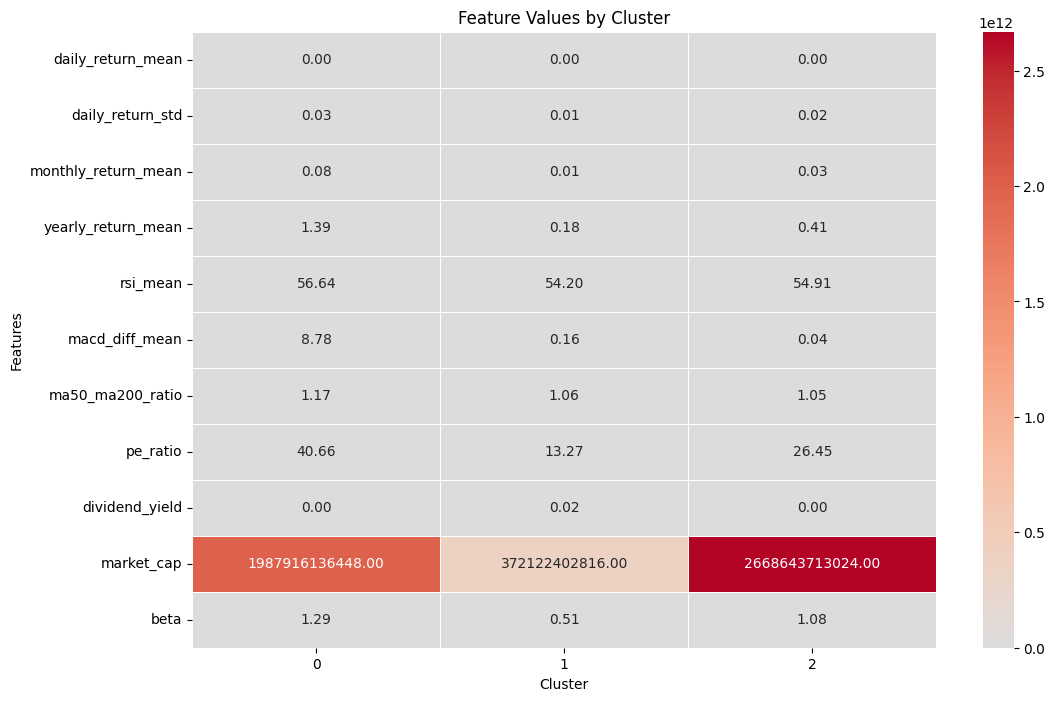

In [80]:
# Example usage
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'PG', '^GSPC', 'BTC-USD']
end_date = datetime.now()
start_date = end_date - timedelta(days=365*2)  # 2 years of data

# Initialize and run the system
stock_system = StockClusteringSystem(tickers, start_date.strftime('%Y-%m-%d'),
                                    end_date.strftime('%Y-%m-%d'))

print("Fetching data...")
stock_system.fetch_data()

print("Creating feature matrix...")
stock_system.create_feature_matrix()

print("Preprocessing features...")
stock_system.preprocess_features()

print("Performing clustering...")
stock_system.perform_clustering(n_clusters=3)

# Get cluster characteristics
risk_mapping = stock_system.get_cluster_characteristics()
print("\nCluster Risk Mappings:")
print(risk_mapping)

# Get recommendations for each risk level
risk_levels = ['Safe', 'Semi-Aggressive', 'Aggressive']
for risk in risk_levels:
    recommendations = stock_system.get_recommendations(risk)
    print(f"\n{risk} stock recommendations:")
    print(recommendations)

print("\nCreating visualizations...")
visualize_results(stock_system)

In [ ]:
# def plot_cluster_3d(self):
#     """
#     Create 3D visualization of clusters using PCA
#     """
#     # Perform PCA for 3D visualization
#     pca = PCA(n_components=3)
#     pca_result = pca.fit_transform(self.scaled_features)

#     # Create DataFrame for plotting
#     plot_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
#     plot_df['Cluster'] = self.features['Cluster']
#     plot_df['Ticker'] = self.features.index

#     # Create interactive 3D scatter plot
#     fig = px.scatter_3d(plot_df, x='PC1', y='PC2', z='PC3',
#                         color='Cluster',
#                         text='Ticker',
#                         title='Stock Clusters Visualization (3D PCA)',
#                         labels={'Cluster': 'Cluster'})

#     fig.update_traces(marker=dict(size=5), textposition='top center')
#     fig.update_layout(scene=dict(
#         xaxis_title='PC1',
#         yaxis_title='PC2',
#         zaxis_title='PC3'
#     ))

#     return fig

# def visualize_results(stock_system):
#     """
#     Create and display all visualizations
#     """
#     viz = StockVisualization(stock_system)

#     # Generate all plots
#     cluster_2d = viz.plot_cluster_2d()
#     risk_return = viz.plot_risk_return_scatter()
#     performance = viz.plot_cluster_performance()
#     metrics = viz.plot_cluster_metrics()
#     cluster_3d = viz.plot_cluster_3d()  # New 3D visualization

#     # Display plots
#     cluster_2d.show()
#     risk_return.show()
#     performance.show()
#     metrics.show()
#     cluster_3d.show()  # Display 3D plot

#     # Feature importance heatmap (using matplotlib)
#     feature_importance = viz.plot_feature_importance()
#     plt.show()